![JohnSnowLabs](https://nlp.johnsnowlabs.com/assets/images/logo.png)



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/JohnSnowLabs/spark-nlp-workshop/blob/master/tutorials/Certification_Trainings/Public/5.Text_Classification_with_ClassifierDL.ipynb)

# Text Classification with ClassifierDL

**Relevant blogpost:** https://towardsdatascience.com/text-classification-in-spark-nlp-with-bert-and-universal-sentence-encoders-e644d618ca32

## Colab Setup

In [1]:
import os

# Install java
! apt-get update -qq
! apt-get install -y openjdk-8-jdk-headless -qq > /dev/null

os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["PATH"] = os.environ["JAVA_HOME"] + "/bin:" + os.environ["PATH"]
! java -version

# Install pyspark
! pip install --ignore-installed -q pyspark==2.4.4
! pip install --ignore-installed -q spark-nlp==2.5.4

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)
     |████████████████████████████████| 215.7MB 55kB/s 
     |████████████████████████████████| 204kB 43.4MB/s 
     |████████████████████████████████| 133kB 6.4MB/s 


In [2]:
import sparknlp

spark = sparknlp.start() # for GPU training >> sparknlp.start(gpu = True) # for Spark 2.3 =>> sparknlp.start(spark23 = True)

from sparknlp.base import *
from sparknlp.annotator import *
from pyspark.ml import Pipeline
import pandas as pd

print("Spark NLP version", sparknlp.version())

print("Apache Spark version:", spark.version)

spark

Spark NLP version 2.5.4
Apache Spark version: 2.4.4


## Using Pretrained ClassifierDL and SentimentDL models

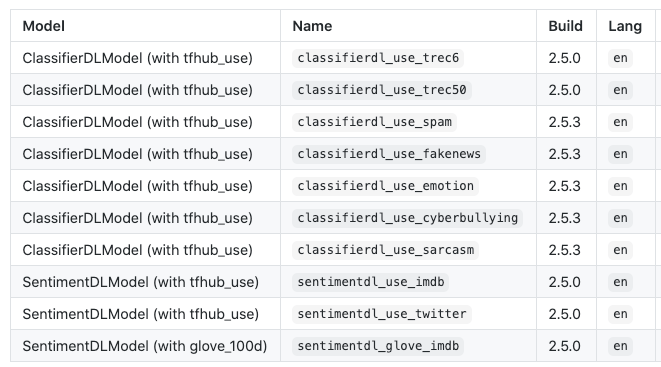

trained on the TREC datasets:

Classify open-domain, fact-based questions into one of the following broad semantic categories: Abbreviation, Description, Entities, Human Beings, Locations or Numeric Values.

In [50]:
def get_clf_lp(model_name, sentiment_dl=False, pretrained=True):

  documentAssembler = DocumentAssembler()\
      .setInputCol("text")\
      .setOutputCol("document")

  use = UniversalSentenceEncoder.pretrained(lang="en") \
  .setInputCols(["document"])\
  .setOutputCol("sentence_embeddings")


  if pretrained:

    if sentiment_dl:

      document_classifier = SentimentDLModel.pretrained(model_name, 'en') \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")
    else:
      document_classifier = ClassifierDLModel.pretrained(model_name, 'en') \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")

  else:

    if sentiment_dl:

      document_classifier = SentimentDLModel.load(model_name) \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")
    else:
      document_classifier = ClassifierDLModel.load(model_name) \
                .setInputCols(["document", "sentence_embeddings"]) \
                .setOutputCol("class")

  nlpPipeline = Pipeline(stages=[
  documentAssembler, 
  use,
  document_classifier
  ])

  empty_data = spark.createDataFrame([[""]]).toDF("text")

  clf_pipelineFit = nlpPipeline.fit(empty_data)

  clf_lp_pipeline = LightPipeline(clf_pipelineFit)

  return clf_lp_pipeline

  



In [21]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_trec50')

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_trec50 download started this may take some time.
Approximate size to download 21.2 MB
[OK!]


In [8]:
text = 'What was the number of member nations of the U.N. in 2000?'

clf_lp_pipeline.annotate(text)['class']

[' NUM_count']

In [13]:
clf_lp_pipeline.fullAnnotate(text)[0]['class'][0].result

' NUM_count'

In [17]:
clf_lp_pipeline.fullAnnotate(text)[0]['class'][0].metadata

{' ENTY_dismed': '1.7313831E-26', ' ENTY_product': '3.634746E-27', ' ENTY_techmeth': '2.264075E-26', ' NUM_speed': '1.308014E-26', ' NUM_volsize': '6.722809E-28', ' LOC_state': '6.33832E-30', ' NUM_code': '1.339242E-26', ' NUM_count': '0.99992645', ' ENTY_food': '3.185541E-29', ' ENTY_animal': '3.249227E-28', ' NUM_period': '3.8844773E-25', ' ENTY_religion': '1.2567344E-26', ' LOC_country': '7.5365026E-24', ' LOC_mount': '5.6770464E-28', ' ENTY_termeq': '6.9577554E-29', ' ENTY_color': '2.3617933E-27', ' ENTY_lang': '1.1541718E-28', ' ENTY_sport': '1.591121E-29', ' DESC_def': '1.6701162E-29', ' HUM_gr': '7.091296E-24', ' ENTY_symbol': '3.1473133E-28', ' ENTY_currency': '5.094744E-33', ' ENTY_veh': '2.994516E-28', ' LOC_other': '6.0477644E-16', ' ENTY_word': '1.3657634E-29', ' NUM_temp': '4.717617E-28', ' NUM_dist': '2.7289194E-29', ' DESC_desc': '1.7242621E-14', ' DESC_manner': '5.3869354E-25', ' NUM_ord': '1.0586453E-31', ' NUM_other': '5.864289E-31', ' DESC_reason': '1.5721213E-15', '

In [7]:
text = 'What animal was the first mammal successfully cloned from adult cells?'

clf_lp_pipeline.annotate(text)['class']

[' HUM_ind']

In [22]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_cyberbullying')


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_cyberbullying download started this may take some time.
Approximate size to download 21.4 MB
[OK!]


In [19]:
text ='RT @EBeisner @ahall012 I agree with you!! I would rather brush my teeth with sandpaper then watch football with a girl!!'

clf_lp_pipeline.annotate(text)['class']

['sexism']

In [23]:
clf_lp_pipeline = get_clf_lp('classifierdl_use_fakenews')


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_fakenews download started this may take some time.
Approximate size to download 21.4 MB
[OK!]


In [25]:
text ='Donald Trump a KGB Spy? 11/02/2016 In today’s video, Christopher Greene of AMTV reports Hillary Clinton campaign accusation that Donald Trump is a KGB spy is about as weak and baseless a claim as a Salem witch hunt or McCarthy era trial. It’s only because Hillary Clinton is losing that she is lobbing conspiracy theory. Citizen Quasar The way I see it, one of two things will happen: 1. Trump will win by a landslide but the election will be stolen via electronic voting, just like I have been predicting for over a decade, and the American People will accept the skewed election results just like they accept the TSA into their crotches. 2. Somebody will bust a cap in Hillary’s @$$ killing her and the election will be postponed. Follow AMTV!'

clf_lp_pipeline.annotate(text)['class']


['FAKE']

In [26]:
text ='Sen. Marco Rubio (R-Fla.) is adding a veteran New Hampshire political operative to his team as he continues mulling a possible 2016 presidential bid, the latest sign that he is seriously preparing to launch a campaign later this year.Jim Merrill, who worked for former GOP presidential nominee Mitt Romney and ran his 2008 and 2012 New Hampshire primary campaigns, joined Rubio’s fledgling campaign on Monday, aides to the senator said.Merrill will be joining Rubio’s Reclaim America PAC to focus on Rubio’s New Hampshire and broader Northeast political operations."Marco has always been well received in New Hampshire, and should he run for president, he would be very competitive there," Terry Sullivan, who runs Reclaim America, said in a statement. "Jim certainly knows how to win in New Hampshire and in the Northeast, and will be a great addition to our team at Reclaim America.”News of Merrill’s hire was first reported by The New York Times.'

clf_lp_pipeline.annotate(text)['class']

['REAL']

In [28]:
sentiment_lp_pipeline = get_clf_lp('sentimentdl_use_twitter', sentiment_dl=True)

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
sentimentdl_use_twitter download started this may take some time.
Approximate size to download 11.9 MB
[OK!]


In [29]:
text ='I am SO happy the news came out in time for my birthday this weekend! My inner 7-year-old cannot WAIT!'

sentiment_lp_pipeline.annotate(text)['class']

['positive']

In [31]:
sentiment_lp_pipeline = get_clf_lp('classifierdl_use_emotion', sentiment_dl=False)


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]
classifierdl_use_emotion download started this may take some time.
Approximate size to download 20.7 MB
[OK!]


In [32]:
sentiment_lp_pipeline.annotate(text)['class']

['surprise']

## ClassiferDL with Word Embeddings and Text Preprocessing

### Load Dataset

In [ ]:
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_train.csv
! wget -q https://raw.githubusercontent.com/JohnSnowLabs/spark-nlp-workshop/master/tutorials/Certification_Trainings/Public/data/news_category_test.csv

In [34]:
!ls -lt

total 24948
-rw-r--r-- 1 root root  1504408 Jul 27 12:56 news_category_test.csv
-rw-r--r-- 1 root root 24032125 Jul 27 12:56 news_category_train.csv
drwxr-xr-x 1 root root     4096 Jul 10 16:29 sample_data


In [35]:
trainDataset = spark.read \
      .option("header", True) \
      .csv("news_category_train.csv")

trainDataset.show(truncate=50)

+--------+--------------------------------------------------+
|category|                                       description|
+--------+--------------------------------------------------+
|Business| Short sellers, Wall Street's dwindling band of...|
|Business| Private investment firm Carlyle Group, which h...|
|Business| Soaring crude prices plus worries about the ec...|
|Business| Authorities have halted oil export flows from ...|
|Business| Tearaway world oil prices, toppling records an...|
|Business| Stocks ended slightly higher on Friday but sta...|
|Business| Assets of the nation's retail money market mut...|
|Business| Retail sales bounced back a bit in July, and n...|
|Business|" After earning a PH.D. in Sociology, Danny Baz...|
|Business| Short sellers, Wall Street's dwindling  band o...|
|Business| Soaring crude prices plus worries  about the e...|
|Business| OPEC can do nothing to douse scorching  oil pr...|
|Business| Non OPEC oil exporters should consider  increa...|
|Busines

In [ ]:
trainDataset.count()


120000

In [36]:
from pyspark.sql.functions import col

trainDataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|Sci/Tech|30000|
|   World|30000|
|  Sports|30000|
|Business|30000|
+--------+-----+



In [45]:
testDataset = spark.read \
      .option("header", True) \
      .csv("news_category_test.csv")


testDataset.groupBy("category") \
    .count() \
    .orderBy(col("count").desc()) \
    .show()

+--------+-----+
|category|count|
+--------+-----+
|   World| 1900|
|  Sports| 1900|
|Sci/Tech| 1900|
|Business| 1900|
+--------+-----+



In [ ]:
# if we want to split the dataset
'''
(trainingData, testData) = trainDataset.randomSplit([0.7, 0.3], seed = 100)
print("Training Dataset Count: " + str(trainingData.count()))
print("Test Dataset Count: " + str(testData.count()))
'''

In [37]:
document_assembler = DocumentAssembler() \
    .setInputCol("description") \
    .setOutputCol("document")
    
tokenizer = Tokenizer() \
  .setInputCols(["document"]) \
  .setOutputCol("token")
    
normalizer = Normalizer() \
    .setInputCols(["token"]) \
    .setOutputCol("normalized")

stopwords_cleaner = StopWordsCleaner()\
      .setInputCols("normalized")\
      .setOutputCol("cleanTokens")\
      .setCaseSensitive(False)

lemma = LemmatizerModel.pretrained('lemma_antbnc') \
    .setInputCols(["cleanTokens"]) \
    .setOutputCol("lemma")

glove_embeddings = WordEmbeddingsModel().pretrained() \
 .setInputCols(["document",'lemma'])\
 .setOutputCol("embeddings")\
 .setCaseSensitive(False)

embeddingsSentence = SentenceEmbeddings() \
      .setInputCols(["document", "embeddings"]) \
      .setOutputCol("sentence_embeddings") \
      .setPoolingStrategy("AVERAGE")

classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("category")\
  .setMaxEpochs(3)\
  .setEnableOutputLogs(True)
  #.setOutputLogsPath('logs')

clf_pipeline = Pipeline(
    stages=[document_assembler, 
            tokenizer,
            normalizer,
            stopwords_cleaner, 
            lemma, 
            glove_embeddings,
            embeddingsSentence,
            classsifierdl])

lemma_antbnc download started this may take some time.
Approximate size to download 907.6 KB
[OK!]
glove_100d download started this may take some time.
Approximate size to download 145.3 MB
[OK!]


In [ ]:
'''
default classifierDL params:

maxEpochs -> 10,
lr -> 5e-3f,
dropout -> 0.5f,
batchSize -> 64,
enableOutputLogs -> false,
verbose -> Verbose.Silent.id,
validationSplit -> 0.0f,
outputLogsPath -> ""
'''

In [ ]:
# Train (8 min for 10 epochs)
%%time

clf_pipelineModel = clf_pipeline.fit(trainDataset)

CPU times: user 158 ms, sys: 29.5 ms, total: 188 ms
Wall time: 8min 22s


In [ ]:
!cd ~/annotator_logs && ls -l


total 4
-rw-r--r-- 1 root root 976 Apr  7 16:59 ClassifierDLApproach_f222663dfb2c.log


In [ ]:
!cat ~/annotator_logs/ClassifierDLApproach_f222663dfb2c.log


Training started - total epochs: 10 - learning rate: 0.005 - batch size: 64 - training examples: 120000
Epoch 0/10 - 35.42044908%.2fs - loss: 1637.3722 - accuracy: 0.8689917 - batches: 1875
Epoch 1/10 - 36.031757286%.2fs - loss: 1609.2766 - accuracy: 0.88155836 - batches: 1875
Epoch 2/10 - 34.908468392%.2fs - loss: 1603.4879 - accuracy: 0.886125 - batches: 1875
Epoch 3/10 - 34.849212057%.2fs - loss: 1596.2185 - accuracy: 0.889725 - batches: 1875
Epoch 4/10 - 34.979911249%.2fs - loss: 1592.2081 - accuracy: 0.89270836 - batches: 1875
Epoch 5/10 - 35.059568873%.2fs - loss: 1588.2047 - accuracy: 0.89515835 - batches: 1875
Epoch 6/10 - 34.855471653%.2fs - loss: 1583.6277 - accuracy: 0.8974583 - batches: 1875
Epoch 7/10 - 34.498874087%.2fs - loss: 1579.1383 - accuracy: 0.89934164 - batches: 1875
Epoch 8/10 - 35.507189799%.2fs - loss: 1575.4302 - accuracy: 0.90068334 - batches: 1875
Epoch 9/10 - 34.665519006%.2fs - loss: 1572.7279 - accuracy: 0.9023167 - batches: 1875


In [ ]:
# get the predictions on test Set

preds = clf_pipelineModel.transform(testDataset)


In [ ]:
preds = clf_pipelineModel.transform(testDataset)

preds.select('category','description',"class.result").show(10, truncate=80)


+--------+--------------------------------------------------------------------------------+----------+
|category|                                                                     description|    result|
+--------+--------------------------------------------------------------------------------+----------+
|Business|Unions representing workers at Turner   Newall say they are 'disappointed' af...|[Business]|
|Sci/Tech| TORONTO, Canada    A second team of rocketeers competing for the  #36;10 mil...|[Sci/Tech]|
|Sci/Tech| A company founded by a chemistry researcher at the University of Louisville ...|[Sci/Tech]|
|Sci/Tech| It's barely dawn when Mike Fitzpatrick starts his shift with a blur of color...|  [Sports]|
|Sci/Tech| Southern California's smog fighting agency went after emissions of the bovin...|   [World]|
|Sci/Tech|"The British Department for Education and Skills (DfES) recently launched a "...|[Sci/Tech]|
|Sci/Tech|"confessed author of the Netsky and Sasser viruses, is responsi

In [ ]:
preds_df = preds.select('category','description',"class.result").toPandas()

# The result is an array since in Spark NLP you can have multiple sentences.
# Let's explode the array and get the item(s) inside of result column out
preds_df['result'] = preds_df['result'].apply(lambda x : x[0])


In [ ]:
# We are going to use sklearn to evalute the results on test dataset
from sklearn.metrics import classification_report

print (classification_report(preds_df['result'], preds_df['category']))


              precision    recall  f1-score   support

    Business       0.84      0.84      0.84      1908
    Sci/Tech       0.86      0.86      0.86      1914
      Sports       0.97      0.95      0.96      1938
       World       0.88      0.91      0.89      1840

    accuracy                           0.89      7600
   macro avg       0.89      0.89      0.89      7600
weighted avg       0.89      0.89      0.89      7600



## ClassifierDL with Universal Sentence Embeddings

In [38]:
# actual content is inside description column
document = DocumentAssembler()\
    .setInputCol("description")\
    .setOutputCol("document")
    
# we can also use sentece detector here if we want to train on and get predictions for each sentence

use = UniversalSentenceEncoder.pretrained()\
 .setInputCols(["document"])\
 .setOutputCol("sentence_embeddings")

# the classes/labels/categories are in category column
classsifierdl = ClassifierDLApproach()\
  .setInputCols(["sentence_embeddings"])\
  .setOutputCol("class")\
  .setLabelColumn("category")\
  .setMaxEpochs(5)\
  .setEnableOutputLogs(True)

use_clf_pipeline = Pipeline(
    stages = [
        document,
        use,
        classsifierdl
    ])

tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [40]:
use_pipelineModel = use_clf_pipeline.fit(trainDataset)
# 5 epochs takes around 10 min

In [41]:
!cd ~/annotator_logs && ls -l


total 4
-rw-r--r-- 1 root root 533 Jul 27 13:13 ClassifierDLApproach_524181565fd1.log


In [42]:
!cat ~/annotator_logs/ClassifierDLApproach_524181565fd1.log


Training started - total epochs: 5 - learning rate: 0.005 - batch size: 64 - training examples: 120000
Epoch 0/5 - 36.532174881%.2fs - loss: 1624.0251 - accuracy: 0.8813 - batches: 1875
Epoch 1/5 - 34.372610287%.2fs - loss: 1597.7561 - accuracy: 0.89163333 - batches: 1875
Epoch 2/5 - 34.589534466%.2fs - loss: 1594.4141 - accuracy: 0.89676666 - batches: 1875
Epoch 3/5 - 34.977971503%.2fs - loss: 1586.4642 - accuracy: 0.90078336 - batches: 1875
Epoch 4/5 - 34.267461476%.2fs - loss: 1581.4093 - accuracy: 0.9034333 - batches: 1875


## Getting prediction from Trained model

In [78]:
from sparknlp.base import LightPipeline

light_model = LightPipeline(use_pipelineModel)

In [68]:
testDataset.select('description').take(2)

[Row(description="Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul."),
 Row(description=' TORONTO, Canada    A second team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for privately funded suborbital space flight, has officially announced the first launch date for its manned rocket.')]

In [69]:
text='''
Fearing the fate of Italy, the centre-right government has threatened to be merciless with those who flout tough restrictions. 
As of Wednesday it will also include all shops being closed across Greece, with the exception of supermarkets. Banks, pharmacies, pet-stores, mobile phone stores, opticians, bakers, mini-markets, couriers and food delivery outlets are among the few that will also be allowed to remain open.
'''
result = light_model.annotate(text)

result['class']

['Business']

In [71]:
light_model.annotate('the soccer games will be postponed.')

{'class': ['Sports'],
 'document': ['the soccer games will be postponed.'],
 'sentence_embeddings': ['the soccer games will be postponed.']}

### Saving & loading back the trained model

In [48]:
use_pipelineModel.stages

[DocumentAssembler_6cc38ac825d2,
 UNIVERSAL_SENTENCE_ENCODER_4de71669b7ec,
 ClassifierDLModel_fa413e291c22]

In [49]:
use_pipelineModel.stages[2].write().overwrite().save('ClassifierDL_USE_20200727_e5')

In [ ]:
classsifierdlmodel = ClassifierDLModel.load('ClassifierDL_USE_20200727_e5')

In [55]:
clf_lp = get_clf_lp('ClassifierDL_USE_20200727_e5', sentiment_dl=False,  pretrained=False)


tfhub_use download started this may take some time.
Approximate size to download 923.7 MB
[OK!]


In [56]:
clf_lp.annotate(text)['class']

['Business']